<a href="https://colab.research.google.com/github/AnkurMali/IST597_Spring_2022/blob/main/IST597_Building_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# In this tutorial we will build basic CNN for image classification.
Author :- Ankur Mali
* We will define our model and learn how to use keras module to build custom layers
* We will also design our own training loop, that is identical to model.fit in Keras.
* The aim of this excercise is to teach, how to use exisiting Tensorflow API to construct our own module and integrate it with tf.keras API.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(5097)

#Things to do
* Remember to Normalize your data and create validation split from train set.
* Learn about tf.data, tf.slices and also tf.records

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_val = x_train[50000:60000]
x_train = x_train[0:50000]
y_val = y_train[50000:60000]
y_train = y_train[0:50000]
x_train = x_train.astype(np.float32).reshape(-1,28,28,1) / 255.0
x_val = x_val.astype(np.float32).reshape(-1,28,28,1) / 255.0
x_test = x_test.astype(np.float32).reshape(-1,28,28,1) / 255.0
y_train = tf.one_hot(y_train, depth=10)
y_val = tf.one_hot(y_val, depth=10)
y_test = tf.one_hot(y_test, depth=10)
print(x_train.shape)
print(x_test.shape)
print(x_val.shape)
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(128)
train_dataset_full = train_dataset.shuffle(buffer_size=1024).batch(len(train_dataset))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(128)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(128)
print(len(train_dataset))
print(len(test_dataset))

4431872/4422102 [==============================] - 0s 0us/step
(50000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)
391
79


#CNN Post activation Batch Normalization Model
# Create your custom CNN class
* Convolution layers has 4D weights of size (h,w,input_feature, output_feature), where h=height of your kernel and w = width of our kernel. If you add batches then it is 5D.
* Now your model will convolve across your input feature map with kernel and create output feature map, that is then passed to next layer.
* As we have learned in our prior class, to initialize your weights, we use tf.Variable(weight_init(size)), tf.keras.layers.Conv2D will do this for you. Play with the function and see how it works for your problem.
* Few important concepts, learn to save your model after every k epochs and start re-training from last checkpoint. This is very useful, and you don't need to retrain your model from scratch.


In [3]:
class ImageRecognitionCNN(tf.keras.Model):
    
    def __init__(self, num_classes, device='cpu:0', checkpoint_directory=None):
        ''' Define the parameterized layers used during forward-pass, the device
            where you would like to run the computation (GPU, TPU, CPU) on and the checkpoint
            directory.
            
            Args:
                num_classes: the number of labels in the network.
                device: string, 'cpu:n' or 'gpu:n' (n can vary). Default, 'cpu:0'.
                checkpoint_directory: the directory where you would like to save or 
                                      restore a model.
        ''' 
        super(ImageRecognitionCNN, self).__init__()
        
        # Initialize layers
        self.conv1 = tf.keras.layers.Conv2D(64, 3, padding='same', activation=None)
        self.conv2 = tf.keras.layers.Conv2D(64, 3,padding='same', activation=None)
        self.pool1 = tf.keras.layers.MaxPool2D()
        self.conv3 = tf.keras.layers.Conv2D(64, 3, padding='same', activation=None)
        self.conv4 = tf.keras.layers.Conv2D(64, 3, padding='same', activation=None)
        self.pool2 = tf.keras.layers.MaxPool2D()
        self.conv5 = tf.keras.layers.Conv2D(num_classes, 1, padding='same', activation=None)
        self.bn1 = tf.keras.layers.BatchNormalization(momentum=0.09, epsilon=0.1)
        self.bn2 = tf.keras.layers.BatchNormalization(momentum=0.009, epsilon=0.1)
        self.bn3 = tf.keras.layers.BatchNormalization(momentum=0.09, epsilon=0.1)
        self.bn4 = tf.keras.layers.BatchNormalization(momentum=0.08, epsilon=0.1)
        self.bn5 = tf.keras.layers.BatchNormalization(momentum=0.008, epsilon=0.1)
        
        # Define the device 
        self.device = device
        
        # Define the checkpoint directory
        self.checkpoint_directory = checkpoint_directory
        self.acc = tf.keras.metrics.Accuracy()
        self.momentum,self.epsilon=0.99,0.1
        self.size_input = x_train.shape[1]
        self.size_hidden1 = 128
        self.size_hidden2 = 128
        self.size_hidden3 = 128
        self.size_output = 10
        self.gamma=[]
        self.beta=[]
        self.moving_mean=[]
        self.moving_variance=[]
        self.sample_mean=[]
        self.sample_variance=[]
        self.BN_init()

    #Calculating sample mean,varience
    def batch_mean_variance(self,Z):
      self.sample_mean.append(tf.math.reduce_mean(Z))
      self.sample_variance.append(tf.math.reduce_variance(Z))

    #Assigning sample mean,varience to moving mean,varience
    def average_assignment(self, move_mean, mean_sample,move_variance,variance_sample):
        #assigning mean and varience
        move_mean.assign(move_mean * self.momentum + mean_sample * (1 - self.momentum))
        move_variance.assign(move_variance * self.momentum + variance_sample * (1 - self.momentum))

    #Batch Normilization
    def BN(self, X, gamma, beta, moving_mean, moving_varience):
      return gamma * (X - moving_mean) / tf.math.sqrt(moving_varience + self.epsilon) + beta

    #Intialize function for batch normalization
    def BN_init(self):
      #Initialize batch normalization scale parameter gamma
      self.gamma = [tf.Variable(tf.ones([1, self.size_input])), tf.Variable(tf.ones([1, self.size_hidden1])), \
                tf.Variable(tf.ones([1, self.size_hidden2])), tf.Variable(tf.ones([1, self.size_hidden3]))]
                
      # Initialize batch normalization shift parameter beta
      self.beta = [tf.Variable(tf.zeros([1, self.size_input])), tf.Variable(tf.zeros([1, self.size_hidden1])),\
               tf.Variable(tf.zeros([1, self.size_hidden2])), tf.Variable(tf.zeros([1, self.size_hidden3]))]

      # The moving mean and variance 
      self.moving_mean = [tf.Variable(tf.zeros([1, self.size_input])), tf.Variable(tf.zeros([1, self.size_hidden1])),\
                       tf.Variable(tf.zeros([1, self.size_hidden2])), tf.Variable(tf.zeros([1, self.size_hidden3]))]

      self.moving_variance = [tf.Variable(tf.ones([1, self.size_input])), tf.Variable(tf.ones([1, self.size_hidden1])),\
                           tf.Variable(tf.ones([1, self.size_hidden2])), tf.Variable(tf.ones([1, self.size_hidden3]))]
   


    def predict(self, images, training):
        """ Predicts the probability of each class, based on the input sample.
            
            Args:
                images: 4D tensor. Either an image or a batch of images.
                training: Boolean. Either the network is predicting in
                          training mode or not.
        """
        x = self.conv1(images)
        hhat1 = tf.nn.relu(x)
        #self.batch_mean_variance(hhat1)
        x = self.bn1(x)
        """
        if training:
          hhat1 = self.BN(x, self.gamma[0], self.beta[0],self.sample_mean[0], self.sample_variance[0])
          self.average_assignment( self.moving_mean[0],self.sample_mean[0],self.moving_variance[0], self.sample_variance[0])
        else:
          x = self.BN(x, self.gamma[0], self.beta[0], self.moving_mean[0], self.moving_variance[0])
        """
        x = self.pool1(x)
        x = self.conv2(x)
        x = tf.nn.relu(x)
        
        x = self.bn2(x)
        x = self.pool1(x)
        x = self.conv3(x)
        x = tf.nn.relu(x)
        """
        if training:
          x = self.BN(x, self.gamma[1], self.beta[1],self.sample_mean[1], self.sample_variance[1])
          self.average_assignment( self.moving_mean[1],self.sample_mean[1],self.moving_variance[1], self.sample_variance[1])
        else:
          x = self.BN(x, self.gamma[1], self.beta[1], self.moving_mean[1], self.moving_variance[1])

        """
        x = self.bn3(x)
        """
        if training:
          x = self.BN(x, self.gamma[2], self.beta[2],self.sample_mean[2], self.sample_variance[2])
          self.average_assignment( self.moving_mean[2],self.sample_mean[2],self.moving_variance[2], self.sample_variance[2])
        else:
          x = self.BN(x, self.gamma[2], self.beta[2], self.moving_mean[2], self.moving_variance[2])
        """
        x = self.bn4(x)
        x = self.pool2(x)
        x = self.conv4(x)
        x = tf.nn.relu(x)
        """
        if training:
          x = self.BN(x, self.gamma[0], self.beta[0],self.sample_mean[0], self.sample_variance[0])
          self.average_assignment( self.moving_mean[0],self.sample_mean[0],self.moving_variance[0], self.sample_variance[0])
        else:
          x = self.BN(x, self.gamma[0], self.beta[0], self.moving_mean[0], self.moving_variance[0])
        """
        x = self.pool2(x)
        x = self.conv5(x)
        #x = tf.nn.relu(x)
        #print(x.shape)
        x = tf.reshape(x, (-1, 1, 10))
        #x = tf.keras.layers.Flatten(x)
        return x



    def loss_fn(self, images, target, training):
        """ Defines the loss function used during 
            training.         
        """
        preds = self.predict(images, training)
        #print(preds.shape)
        #print(target.shape)
        loss = tf.nn.softmax_cross_entropy_with_logits(labels=target, logits=preds)
        return loss


    def grads_fn(self, images, target, training):
        """ Dynamically computes the gradients of the loss value
            with respect to the parameters of the model, in each
            forward pass.
        """
        with tf.GradientTape() as tape:
            loss = self.loss_fn(images, target, training)
        return tape.gradient(loss, self.variables)
    
    def restore_model(self):
        """ Function to restore trained model.
        """
        with tf.device(self.device):
            # Run the model once to initialize variables
            dummy_input = tf.constant(tf.zeros((1,48,48,1)))
            dummy_pred = self.predict(dummy_input, training=False)
            # Restore the variables of the model
            saver = tf.Saver(self.variables)
            saver.restore(tf.train.latest_checkpoint
                          (self.checkpoint_directory))
    
    def save_model(self, global_step=0):
        """ Function to save trained model.
        """
        tf.Saver(self.variables).save(self.checkpoint_directory, 
                                       global_step=global_step)   
    
    # def compute_accuracy(self, input_data):
    #     """ Compute the accuracy on the input data.
    #     """
    #     with tf.device(self.device):
    #         #acc = tf.metrics.Accuracy()
    #         for step ,(images, targets) in enumerate(input_data):
    #             # Predict the probability of each class
    #             #print(targets.shape)
    #             logits = self.predict(images, training=False)
    #             # Select the class with the highest probability
    #             #print(logits.shape)
    #             logits = tf.nn.softmax(logits)
    #             logits = tf.reshape(logits, [-1, 10])
    #             targets = tf.reshape(targets, [-1,10])
    #             preds = tf.argmax(logits, axis=1)
                
    #             #m1.update_state
    #             # Compute the accuracy
    #             #print(preds.shape)
    #             acc(tf.reshape(targets, preds))
    #     return acc

    def compute_accuracy_2(self, images, targets):
        """ Compute the accuracy on the input data.
        """
        with tf.device(self.device):
            
            # Predict the probability of each class
            logits = self.predict(images, training=False)
            # Select the class with the highest probability
            
            logits = tf.nn.softmax(logits)
            logits = tf.reshape(logits, [-1, 10])
            targets = tf.reshape(targets, [-1,10])
            preds = tf.argmax(logits, axis=1)
            goal = tf.argmax(targets, axis=1)
            self.acc.update_state(goal, preds)
            # Compute the accuracy
            result = self.acc.result().numpy()
        return result

  
    def fit_fc(self, training_data, eval_data,test_data, optimizer, num_epochs=500, 
            early_stopping_rounds=10, verbose=10, train_from_scratch=False):
        """ Function to train the model, using the selected optimizer and
            for the desired number of epochs. You can either train from scratch
            or load the latest model trained. Early stopping is used in order to
            mitigate the risk of overfitting the network.
            
            Args:
                training_data: the data you would like to train the model on.
                                Must be in the tf.data.Dataset format.
                eval_data: the data you would like to evaluate the model on.
                            Must be in the tf.data.Dataset format.
                optimizer: the optimizer used during training.
                num_epochs: the maximum number of iterations you would like to 
                            train the model.
                early_stopping_rounds: stop training if the loss on the eval 
                                       dataset does not decrease after n epochs.
                verbose: int. Specify how often to print the loss value of the network.
                train_from_scratch: boolean. Whether to initialize variables of the
                                    the last trained model or initialize them
                                    randomly.
        """ 
    
        if train_from_scratch==False:
            self.restore_model()
        
        # Initialize best loss. This variable will store the lowest loss on the
        # eval dataset.
        best_loss = 999
        
        # Initialize classes to update the mean loss of train and eval
        train_loss = tf.keras.metrics.Mean('train_loss')
        eval_loss = tf.keras.metrics.Mean('eval_loss')
        test_loss = tf.keras.metrics.Mean('test_loss')
        acc_train = tf.keras.metrics.Mean('train_acc')
        acc_val = tf.keras.metrics.Mean('val_acc')
        acc_test = tf.keras.metrics.Mean('test_acc')
        
        # Initialize dictionary to store the loss history
        self.history = {}
        self.history['train_loss'] = []
        self.history['eval_loss'] = []
        self.history['test_loss'] = []
        self.history['train_acc'] = []
        self.history['val_acc'] = []
        self.history['test_acc'] = []
        
        # Begin training
        with tf.device(self.device):
            for i in range(num_epochs):
                # Training with gradient descent
                #training_data_x = training_data.shuffle(buffer_size=1024).batch(128)
                for step, (images, target) in enumerate(training_data):
                    grads = self.grads_fn(images, target, True)
                    optimizer.apply_gradients(zip(grads, self.variables))
                    
                # Compute the loss on the training data after one epoch
                for step, (images, target) in enumerate(training_data):
                    loss = self.loss_fn(images, target, False)
                    accuracy = self.compute_accuracy_2(images,target)
                    acc_train(accuracy)
                    train_loss(loss)
                self.history['train_loss'].append(train_loss.result().numpy())
                self.history['train_acc'].append(acc_train.result().numpy())
                # Reset metrics
                train_loss.reset_states()
                acc_train.reset_states()
                
                # Compute the loss on the eval data after one epoch
                for step, (images, target) in enumerate(eval_data):
                    loss = self.loss_fn(images, target, False)
                    accuracy = self.compute_accuracy_2(images,target)
                    acc_val(accuracy)
                    eval_loss(loss)
                self.history['eval_loss'].append(eval_loss.result().numpy())
                self.history['val_acc'].append(acc_val.result().numpy())
                # Reset metrics
                eval_loss.reset_states()
                acc_val.reset_states()

                # Compute the loss on the test data after one epoch
                for step, (images, target) in enumerate(test_data):
                    loss = self.loss_fn(images, target, False)
                    accuracy = self.compute_accuracy_2(images,target)
                    acc_val(accuracy)
                    eval_loss(loss)
                self.history['test_loss'].append(eval_loss.result().numpy())
                self.history['test_acc'].append(acc_val.result().numpy())
                # Reset metrics
                eval_loss.reset_states()
                acc_val.reset_states()
                
                # Print train and eval losses
                if (i==0) | ((i+1)%verbose==0):
                    print('Number of Epoch = {}: Train loss:= {:.4f} - Val loss: {:.4f} - Test loss: {:.4f} - Train acc:= {:.2%} - Val acc:= {:.2%} - Test acc:= {:.2%}'\
                  .format(i+1,self.history['train_loss'][-1], self.history['eval_loss'][-1], self.history['test_loss'][-1], \
                          self.history['train_acc'][-1], self.history['val_acc'][-1], self.history['test_acc'][-1]))

                # Check for early stopping
                if self.history['eval_loss'][-1]<best_loss:
                    best_loss = self.history['eval_loss'][-1]
                    count = early_stopping_rounds
                else:
                    count -= 1
                if count==0:
                  break
        
        tra= np.squeeze(self.history['train_acc'])
        va = np.squeeze(self.history['val_acc'])
        tea=np.squeeze(self.history['test_acc'])
        
        trl= np.squeeze(self.history['train_loss'])
        vl = np.squeeze(self.history['eval_loss'])
        tel=np.squeeze(self.history['test_loss'])

        plt.figure(1)
        plt.plot(tra,label ='Train Accuracy')
        plt.plot(va,label ='Valdiation Accuracy')
        plt.plot(tea,label ='Test Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('iterations ')
        plt.title("Fashion MNIST CNN")
        plt.legend()
        plt.show()

        plt.figure(2)
        plt.plot(trl,label ='Train Loss')
        plt.plot(vl,label ='Valdiation Loss')
        plt.plot(tel,label ='Test Loss')
        plt.ylabel('Loss')
        plt.xlabel('iterations ')
        plt.title("Fashion MNIST CNN")
        plt.legend()
        plt.show()
              

#CNN pre activation Batch Normalization Model

In [4]:
class ImageRecognitionCNNPre(tf.keras.Model):
    
    def __init__(self, num_classes, device='cpu:0', checkpoint_directory=None):
        ''' Define the parameterized layers used during forward-pass, the device
            where you would like to run the computation (GPU, TPU, CPU) on and the checkpoint
            directory.
            
            Args:
                num_classes: the number of labels in the network.
                device: string, 'cpu:n' or 'gpu:n' (n can vary). Default, 'cpu:0'.
                checkpoint_directory: the directory where you would like to save or 
                                      restore a model.
        ''' 
        super(ImageRecognitionCNNPre, self).__init__()
        
        # Initialize layers
        self.conv1 = tf.keras.layers.Conv2D(64, 3, padding='same', activation=None)
        self.conv2 = tf.keras.layers.Conv2D(64, 3,padding='same', activation=None)
        self.pool1 = tf.keras.layers.MaxPool2D()
        self.conv3 = tf.keras.layers.Conv2D(64, 3, padding='same', activation=None)
        self.conv4 = tf.keras.layers.Conv2D(64, 3, padding='same', activation=None)
        self.pool2 = tf.keras.layers.MaxPool2D()
        self.conv5 = tf.keras.layers.Conv2D(num_classes, 1, padding='same', activation=None)
        self.bn1 = tf.keras.layers.BatchNormalization(momentum=0.09, epsilon=0.1)
        self.bn2 = tf.keras.layers.BatchNormalization(momentum=0.009, epsilon=0.1)
        self.bn3 = tf.keras.layers.BatchNormalization(momentum=0.09, epsilon=0.1)
        self.bn4 = tf.keras.layers.BatchNormalization(momentum=0.08, epsilon=0.1)
        self.bn5 = tf.keras.layers.BatchNormalization(momentum=0.008, epsilon=0.1)
        
        # Define the device 
        self.device = device
        
        # Define the checkpoint directory
        self.checkpoint_directory = checkpoint_directory
        self.acc = tf.keras.metrics.Accuracy()
        self.momentum,self.epsilon=0.99,0.1
        self.size_input = x_train.shape[1]
        self.size_hidden1 = 128
        self.size_hidden2 = 128
        self.size_hidden3 = 128
        self.size_output = 10
        self.gamma=[]
        self.beta=[]
        self.moving_mean=[]
        self.moving_variance=[]
        self.sample_mean=[]
        self.sample_variance=[]
        self.BN_init()

    #Calculating sample mean,varience
    def batch_mean_variance(self,Z):
      self.sample_mean.append(tf.math.reduce_mean(Z))
      self.sample_variance.append(tf.math.reduce_variance(Z))

    #Assigning sample mean,varience to moving mean,varience
    def average_assignment(self, move_mean, mean_sample,move_variance,variance_sample):
        #assigning mean and varience
        move_mean.assign(move_mean * self.momentum + mean_sample * (1 - self.momentum))
        move_variance.assign(move_variance * self.momentum + variance_sample * (1 - self.momentum))

    #Batch Normilization
    def BN(self, X, gamma, beta, moving_mean, moving_varience):
      return gamma * (X - moving_mean) / tf.math.sqrt(moving_varience + self.epsilon) + beta

    #Intialize function for batch normalization
    def BN_init(self):
      #Initialize batch normalization scale parameter gamma
      self.gamma = [tf.Variable(tf.ones([1, self.size_input])), tf.Variable(tf.ones([1, self.size_hidden1])), \
                tf.Variable(tf.ones([1, self.size_hidden2])), tf.Variable(tf.ones([1, self.size_hidden3]))]
                
      # Initialize batch normalization shift parameter beta
      self.beta = [tf.Variable(tf.zeros([1, self.size_input])), tf.Variable(tf.zeros([1, self.size_hidden1])),\
               tf.Variable(tf.zeros([1, self.size_hidden2])), tf.Variable(tf.zeros([1, self.size_hidden3]))]

      # The moving mean and variance 
      self.moving_mean = [tf.Variable(tf.zeros([1, self.size_input])), tf.Variable(tf.zeros([1, self.size_hidden1])),\
                       tf.Variable(tf.zeros([1, self.size_hidden2])), tf.Variable(tf.zeros([1, self.size_hidden3]))]

      self.moving_variance = [tf.Variable(tf.ones([1, self.size_input])), tf.Variable(tf.ones([1, self.size_hidden1])),\
                           tf.Variable(tf.ones([1, self.size_hidden2])), tf.Variable(tf.ones([1, self.size_hidden3]))]
   


    

    def predict(self, images, training):
        """ Predicts the probability of each class, based on the input sample.
            
            Args:
                images: 4D tensor. Either an image or a batch of images.
                training: Boolean. Either the network is predicting in
                          training mode or not.
        """
        x = self.conv1(images)
        #self.batch_mean_variance(x)
        x = self.bn1(x)
        """
        if training:
          x = self.BN(x, self.gamma[0], self.beta[0],self.sample_mean[0], self.sample_variance[0])
          self.average_assignment( self.moving_mean[0],self.sample_mean[0],self.moving_variance[0], self.sample_variance[0])
        else:
          x = self.BN(x, self.gamma[0], self.beta[0], self.moving_mean[0], self.moving_variance[0])
        """
        x = tf.nn.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        
        x = self.bn2(x)
        """
        if training:
          x = self.BN(x, self.gamma[1], self.beta[1],self.sample_mean[1], self.sample_variance[1])
          self.average_assignment( self.moving_mean[1],self.sample_mean[1],self.moving_variance[1], self.sample_variance[1])
        else:
          x = self.BN(x, self.gamma[1], self.beta[1], self.moving_mean[1], self.moving_variance[1])
        """
        x = tf.nn.relu(x)
        x = self.pool1(x)
        x = self.conv3(x)

        x = self.bn3(x)
        """
        if training:
          x = self.BN(x, self.gamma[2], self.beta[2],self.sample_mean[2], self.sample_variance[2])
          self.average_assignment( self.moving_mean[2],self.sample_mean[2],self.moving_variance[2], self.sample_variance[2])
        else:
          x = self.BN(x, self.gamma[2], self.beta[2], self.moving_mean[2], self.moving_variance[2])
        """

        x = tf.nn.relu(x)
        x = self.pool2(x)
        x = self.conv4(x)

        x = self.bn4(x)
        """
        if training:
          x = self.BN(x, self.gamma[0], self.beta[0],self.sample_mean[0], self.sample_variance[0])
          self.average_assignment( self.moving_mean[0],self.sample_mean[0],self.moving_variance[0], self.sample_variance[0])
        else:
          x = self.BN(x, self.gamma[0], self.beta[0], self.moving_mean[0], self.moving_variance[0])
        """
        x = tf.nn.relu(x)
        x = self.pool2(x)
        x = self.conv5(x)
        #x = tf.nn.relu(x)
        #print(x.shape)
        x = tf.reshape(x, (-1, 1, 10))
        #x = tf.keras.layers.Flatten(x)
        return x




    def loss_fn(self, images, target, training):
        """ Defines the loss function used during 
            training.         
        """
        preds = self.predict(images, training)
        #print(preds.shape)
        #print(target.shape)
        loss = tf.nn.softmax_cross_entropy_with_logits(labels=target, logits=preds)
        return loss


    def grads_fn(self, images, target, training):
        """ Dynamically computes the gradients of the loss value
            with respect to the parameters of the model, in each
            forward pass.
        """
        with tf.GradientTape() as tape:
            loss = self.loss_fn(images, target, training)
        return tape.gradient(loss, self.variables)
    
    def restore_model(self):
        """ Function to restore trained model.
        """
        with tf.device(self.device):
            # Run the model once to initialize variables
            dummy_input = tf.constant(tf.zeros((1,48,48,1)))
            dummy_pred = self.predict(dummy_input, training=False)
            # Restore the variables of the model
            saver = tf.Saver(self.variables)
            saver.restore(tf.train.latest_checkpoint
                          (self.checkpoint_directory))
    
    def save_model(self, global_step=0):
        """ Function to save trained model.
        """
        tf.Saver(self.variables).save(self.checkpoint_directory, 
                                       global_step=global_step)   
    
    # def compute_accuracy(self, input_data):
    #     """ Compute the accuracy on the input data.
    #     """
    #     with tf.device(self.device):
    #         #acc = tf.metrics.Accuracy()
    #         for step ,(images, targets) in enumerate(input_data):
    #             # Predict the probability of each class
    #             #print(targets.shape)
    #             logits = self.predict(images, training=False)
    #             # Select the class with the highest probability
    #             #print(logits.shape)
    #             logits = tf.nn.softmax(logits)
    #             logits = tf.reshape(logits, [-1, 10])
    #             targets = tf.reshape(targets, [-1,10])
    #             preds = tf.argmax(logits, axis=1)
                
    #             #m1.update_state
    #             # Compute the accuracy
    #             #print(preds.shape)
    #             acc(tf.reshape(targets, preds))
    #     return acc

    def compute_accuracy_2(self, images, targets):
        """ Compute the accuracy on the input data.
        """
        with tf.device(self.device):
            
            # Predict the probability of each class
            logits = self.predict(images, training=False)
            # Select the class with the highest probability
            
            logits = tf.nn.softmax(logits)
            logits = tf.reshape(logits, [-1, 10])
            targets = tf.reshape(targets, [-1,10])
            preds = tf.argmax(logits, axis=1)
            goal = tf.argmax(targets, axis=1)
            self.acc.update_state(goal, preds)
            # Compute the accuracy
            result = self.acc.result().numpy()
        return result

  
    def fit_fc(self, training_data, eval_data,test_data, optimizer, num_epochs=500, 
            early_stopping_rounds=10, verbose=10, train_from_scratch=False):
        """ Function to train the model, using the selected optimizer and
            for the desired number of epochs. You can either train from scratch
            or load the latest model trained. Early stopping is used in order to
            mitigate the risk of overfitting the network.
            
            Args:
                training_data: the data you would like to train the model on.
                                Must be in the tf.data.Dataset format.
                eval_data: the data you would like to evaluate the model on.
                            Must be in the tf.data.Dataset format.
                optimizer: the optimizer used during training.
                num_epochs: the maximum number of iterations you would like to 
                            train the model.
                early_stopping_rounds: stop training if the loss on the eval 
                                       dataset does not decrease after n epochs.
                verbose: int. Specify how often to print the loss value of the network.
                train_from_scratch: boolean. Whether to initialize variables of the
                                    the last trained model or initialize them
                                    randomly.
        """ 
    
        if train_from_scratch==False:
            self.restore_model()
        
        # Initialize best loss. This variable will store the lowest loss on the
        # eval dataset.
        best_loss = 999
        
        # Initialize classes to update the mean loss of train and eval
        train_loss = tf.keras.metrics.Mean('train_loss')
        eval_loss = tf.keras.metrics.Mean('eval_loss')
        test_loss = tf.keras.metrics.Mean('test_loss')
        acc_train = tf.keras.metrics.Mean('train_acc')
        acc_val = tf.keras.metrics.Mean('val_acc')
        acc_test = tf.keras.metrics.Mean('test_acc')
        
        # Initialize dictionary to store the loss history
        self.history = {}
        self.history['train_loss'] = []
        self.history['eval_loss'] = []
        self.history['test_loss'] = []
        self.history['train_acc'] = []
        self.history['val_acc'] = []
        self.history['test_acc'] = []
        
        # Begin training
        with tf.device(self.device):
            for i in range(num_epochs):
                # Training with gradient descent
                #training_data_x = training_data.shuffle(buffer_size=1024).batch(128)
                for step, (images, target) in enumerate(training_data):
                    grads = self.grads_fn(images, target, True)
                    optimizer.apply_gradients(zip(grads, self.variables))
                    
                # Compute the loss on the training data after one epoch
                for step, (images, target) in enumerate(training_data):
                    loss = self.loss_fn(images, target, False)
                    accuracy = self.compute_accuracy_2(images,target)
                    acc_train(accuracy)
                    train_loss(loss)
                self.history['train_loss'].append(train_loss.result().numpy())
                self.history['train_acc'].append(acc_train.result().numpy())
                # Reset metrics
                train_loss.reset_states()
                acc_train.reset_states()
                
                # Compute the loss on the eval data after one epoch
                for step, (images, target) in enumerate(eval_data):
                    loss = self.loss_fn(images, target, False)
                    accuracy = self.compute_accuracy_2(images,target)
                    acc_val(accuracy)
                    eval_loss(loss)
                self.history['eval_loss'].append(eval_loss.result().numpy())
                self.history['val_acc'].append(acc_val.result().numpy())
                # Reset metrics
                eval_loss.reset_states()
                acc_val.reset_states()

                # Compute the loss on the test data after one epoch
                for step, (images, target) in enumerate(test_data):
                    loss = self.loss_fn(images, target, False)
                    accuracy = self.compute_accuracy_2(images,target)
                    acc_val(accuracy)
                    eval_loss(loss)
                self.history['test_loss'].append(eval_loss.result().numpy())
                self.history['test_acc'].append(acc_val.result().numpy())
                # Reset metrics
                eval_loss.reset_states()
                acc_val.reset_states()
                
                # Print train and eval losses
                if (i==0) | ((i+1)%verbose==0):
                    print('Number of Epoch = {}: Train loss:= {:.4f} - Val loss: {:.4f} - Test loss: {:.4f} - Train acc:= {:.2%} - Val acc:= {:.2%} - Test acc:= {:.2%}'\
                  .format(i+1,self.history['train_loss'][-1], self.history['eval_loss'][-1], self.history['test_loss'][-1], \
                          self.history['train_acc'][-1], self.history['val_acc'][-1], self.history['test_acc'][-1]))

                # Check for early stopping
                if self.history['eval_loss'][-1]<best_loss:
                    best_loss = self.history['eval_loss'][-1]
                    count = early_stopping_rounds
                else:
                    count -= 1
                if count==0:
                  break
        
        tra= np.squeeze(self.history['train_acc'])
        va = np.squeeze(self.history['val_acc'])
        tea=np.squeeze(self.history['test_acc'])
        
        trl= np.squeeze(self.history['train_loss'])
        vl = np.squeeze(self.history['eval_loss'])
        tel=np.squeeze(self.history['test_loss'])

        plt.figure(1)
        plt.plot(tra,label ='Train Accuracy')
        plt.plot(va,label ='Valdiation Accuracy')
        plt.plot(tea,label ='Test Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('iterations ')
        plt.title("Fashion MNIST CNN")
        plt.legend()
        plt.show()

        plt.figure(2)
        plt.plot(trl,label ='Train Loss')
        plt.plot(vl,label ='Valdiation Loss')
        plt.plot(tel,label ='Test Loss')
        plt.ylabel('Loss')
        plt.xlabel('iterations ')
        plt.title("Fashion MNIST CNN")
        plt.legend()
        plt.show()
              

In [5]:
# Specify the path where you want to save/restore the trained variables.
checkpoint_directory = 'models_checkpoints/mnist/'

# Use the GPU if available.
device = 'gpu:0'

# Define optimizer.
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=1e-3)

# Instantiate model. This doesn't initialize the variables yet.
model = ImageRecognitionCNN(num_classes=10, device=device, 
                              checkpoint_directory=checkpoint_directory)

modelPre = ImageRecognitionCNNPre(num_classes=10, device=device, 
                              checkpoint_directory=checkpoint_directory)

#model = ImageRecognitionCNN(num_classes=7, device=device)

Number of Epoch = 1: Train loss:= 0.3991 - Val loss: 0.4136 - Test loss: 0.4280 - Train acc:= 85.47% - Val acc:= 85.73% - Test acc:= 85.61%
Number of Epoch = 5: Train loss:= 0.2291 - Val loss: 0.2732 - Test loss: 0.2951 - Train acc:= 88.91% - Val acc:= 89.15% - Test acc:= 89.17%
Number of Epoch = 10: Train loss:= 0.1575 - Val loss: 0.2629 - Test loss: 0.2737 - Train acc:= 90.54% - Val acc:= 90.69% - Test acc:= 90.69%
Number of Epoch = 15: Train loss:= 0.1134 - Val loss: 0.3216 - Test loss: 0.3352 - Train acc:= 91.64% - Val acc:= 91.75% - Test acc:= 91.74%
Number of Epoch = 20: Train loss:= 0.0561 - Val loss: 0.3579 - Test loss: 0.3869 - Train acc:= 92.55% - Val acc:= 92.65% - Test acc:= 92.64%
Number of Epoch = 25: Train loss:= 0.0615 - Val loss: 0.4636 - Test loss: 0.4919 - Train acc:= 93.26% - Val acc:= 93.31% - Test acc:= 93.30%
Number of Epoch = 30: Train loss:= 0.0402 - Val loss: 0.4992 - Test loss: 0.5432 - Train acc:= 93.71% - Val acc:= 93.76% - Test acc:= 93.75%
Number of Epoch

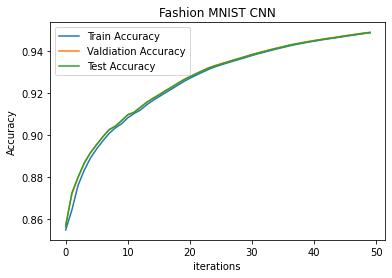

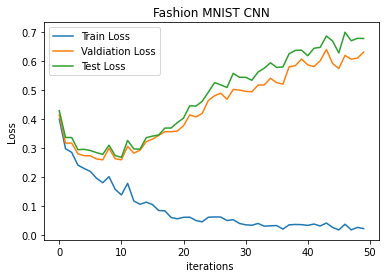

In [6]:
# Train model for post activation and plotting
model.fit_fc(train_dataset, val_dataset,test_dataset, optimizer, num_epochs=50, 
          early_stopping_rounds=50, verbose=5, train_from_scratch=True)

Number of Epoch = 1: Train loss:= 0.3531 - Val loss: 0.3700 - Test loss: 0.3928 - Train acc:= 87.01% - Val acc:= 87.08% - Test acc:= 86.99%
Number of Epoch = 5: Train loss:= 0.1940 - Val loss: 0.2441 - Test loss: 0.2585 - Train acc:= 89.95% - Val acc:= 90.23% - Test acc:= 90.25%
Number of Epoch = 10: Train loss:= 0.1445 - Val loss: 0.2568 - Test loss: 0.2823 - Train acc:= 91.45% - Val acc:= 91.58% - Test acc:= 91.57%
Number of Epoch = 15: Train loss:= 0.0997 - Val loss: 0.2920 - Test loss: 0.3147 - Train acc:= 92.37% - Val acc:= 92.46% - Test acc:= 92.44%
Number of Epoch = 20: Train loss:= 0.0761 - Val loss: 0.3768 - Test loss: 0.4071 - Train acc:= 93.05% - Val acc:= 93.13% - Test acc:= 93.11%
Number of Epoch = 25: Train loss:= 0.0720 - Val loss: 0.4438 - Test loss: 0.4896 - Train acc:= 93.60% - Val acc:= 93.65% - Test acc:= 93.63%
Number of Epoch = 30: Train loss:= 0.0381 - Val loss: 0.4626 - Test loss: 0.4970 - Train acc:= 94.02% - Val acc:= 94.07% - Test acc:= 94.05%
Number of Epoch

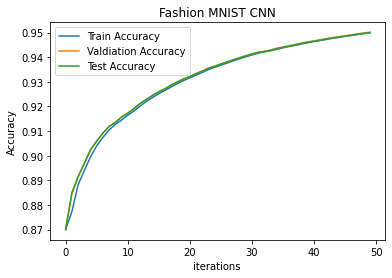

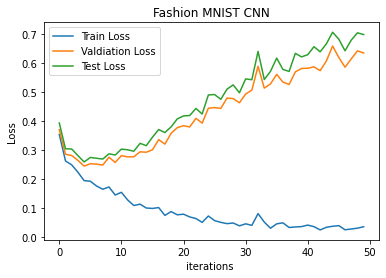

In [7]:
# Train model for pre activation and plotting
modelPre.fit_fc(train_dataset, val_dataset,test_dataset, optimizer, num_epochs=50, 
          early_stopping_rounds=50, verbose=5, train_from_scratch=True)